![](https://rusderevnya.ru/upload/iblock/f19/f197a08720322cf72267644bee5d19d2.jpg)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# Import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import re
from datetime import datetime
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
pd.set_option('display.max_columns', 50)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [12]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
47832,id_7033,Paris,['Japanese'],7034.0,$$ - $$$,26.0,"[['Perfect', 'Small and quaint locals resturan...",/Restaurant_Review-g187147-d793121-Reviews-Le_...,d793121,1,4.0
41333,id_1121,Lisbon,"['Italian', 'Pizza', 'European', 'Mediterranean']",1122.0,$$ - $$$,83.0,"[['Friends night out', 'Great pizza and great ...",/Restaurant_Review-g189158-d2616675-Reviews-Pi...,d2616675,1,4.5
12045,id_213,Copenhagen,"['American', 'Steakhouse', 'European']",214.0,$$$$,241.0,"[['High quality steaks', 'Busy but friendly an...",/Restaurant_Review-g189541-d8776269-Reviews-MA...,d8776269,1,4.0
19171,id_340,Milan,"['Italian', 'Vegetarian Friendly']",341.0,$$$$,134.0,"[['Just landed in milano', 'Great truffle'], [...",/Restaurant_Review-g187849-d11933355-Reviews-S...,d11933355,1,4.5
24271,id_10270,Paris,"['French', 'Bar', 'European']",10272.0,$$ - $$$,75.0,"[['Good address', 'a very poor service'], ['03...",/Restaurant_Review-g187147-d4405016-Reviews-Ba...,d4405016,1,3.5


In [13]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Рассмотрим признаки датасета по отдельности

#### 1. Restaurant_id - порядковый номер ресторана

In [14]:
data.loc[:, ['Restaurant_id']].info()
display(data.Restaurant_id.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
Restaurant_id    50000 non-null object
dtypes: object(1)
memory usage: 390.8+ KB


id_227      19
id_871      19
id_436      19
id_633      19
id_344      18
            ..
id_10721     1
id_11150     1
id_9423      1
id_11945     1
id_13065     1
Name: Restaurant_id, Length: 13094, dtype: int64

нет пропусков но есть повторяющиеся значения - можно сделать вывод что это сеть ресторанов. Добавим новый признак в нашу модель - представим что 0 будет соответствовать уникальному ресторану (id = 1) а 1 будет отвечать сети ресторанов (id > 1)

In [15]:
restaurant_chain = data['Restaurant_id'].value_counts()[data['Restaurant_id'].value_counts() > 1].index.tolist()
data['restaurant_chain'] = data[data['Restaurant_id'].isin(restaurant_chain)].Restaurant_id.apply(lambda x: 1) # заполняем единицей
data['restaurant_chain'] = data['restaurant_chain'].fillna(0) # заполняем остаток 0
data['restaurant_chain'].describe()

count    50000.000000
mean         0.923860
std          0.265225
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: restaurant_chain, dtype: float64

#### 2. City

In [16]:
data.City.value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

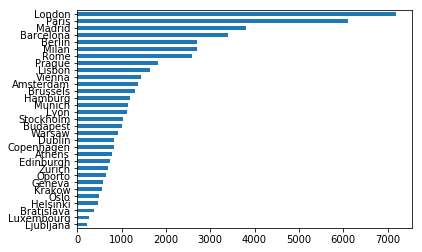

In [17]:
data['City'].value_counts(ascending=True).plot(kind='barh')

In [18]:
# города закодируем с помощью One-Hot Encoding и сохраним названия городов - возможно, используем позже
data['City_name'] = data['City']
data = pd.get_dummies(data, columns=['City'], dummy_na=True)

In [19]:
data.head(2)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,restaurant_chain,City_name,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
0,id_0,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,1.0,Paris,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,id_1,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,1.0,Helsinki,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 3. Cuisine Style - виды кухни которые предствлены в ресторане

In [20]:
display(data['Cuisine Style'].describe())
display(data['Cuisine Style'].isna().value_counts())

count           38410
unique          10731
top       ['Italian']
freq             1332
Name: Cuisine Style, dtype: object

False    38410
True     11590
Name: Cuisine Style, dtype: int64

In [21]:
cuisine_style = data['Cuisine Style'].str.findall(r"'(\b.*?\b)'") # применим регулярные выражения для поиска наиболее частого встречающегося варианта
cuisine_style.explode().value_counts()

Vegetarian Friendly    14021
European               12561
Mediterranean           7820
Italian                 7433
Vegan Options           5684
                       ...  
Yunnan                     2
Xinjiang                   1
Salvadoran                 1
Burmese                    1
Latvian                    1
Name: Cuisine Style, Length: 125, dtype: int64

есть пропуски, наиболее частое встречающиеся значение 'Vegetarian Friendly'. Создадим новый признак на основании этого куда положим все виды кухни списком, пропуски заполним 'European' - как самую обобщающую кухню. Она включает и 'Vegetarian Friendly' и множество остальных

In [22]:
# заполним пропуски
#data['Cuisine Style'].fillna('European')
data['Cuisine Style'] = data['Cuisine Style'].fillna('European')

In [23]:
# выполним преобразование данных
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: str(x).replace('[',''))
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: str(x).replace(']',''))
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: str(x).replace(' ',''))
data['cuisine_style'] = data['Cuisine Style'].apply(lambda x:x.split(','))

In [24]:
data['cuisine_style'].explode().value_counts()

'VegetarianFriendly'    14021
'European'              12561
European                11590
'Mediterranean'          7820
'Italian'                7433
                        ...  
'Fujian'                    2
'Xinjiang'                  1
'Salvadoran'                1
'Latvian'                   1
'Burmese'                   1
Name: cuisine_style, Length: 126, dtype: int64

In [25]:
# Создадим признак, содержащий количество кухонь, представленных в ресторане
data['cuisine_count'] = data['cuisine_style'].apply(lambda x: len(x))

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 46 columns):
Restaurant_id        50000 non-null object
Cuisine Style        50000 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
restaurant_chain     50000 non-null float64
City_name            50000 non-null object
City_Amsterdam       50000 non-null uint8
City_Athens          50000 non-null uint8
City_Barcelona       50000 non-null uint8
City_Berlin          50000 non-null uint8
City_Bratislava      50000 non-null uint8
City_Brussels        50000 non-null uint8
City_Budapest        50000 non-null uint8
City_Copenhagen      50000 non-null uint8
City_Dublin          50000 non-null 

#### 4. Price Range

In [27]:
display(data['Price Range'].describe())
display(data['Price Range'].explode().value_counts())

count        32639
unique           3
top       $$ - $$$
freq         23041
Name: Price Range, dtype: object

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

Есть пропуски - заполним наиболее частым значением, приведем признак к числовому значения через словарь 


In [28]:
#data['Price Range'] = data['Price Range'].fillna('$$ - $$$')
price_dict = {'$': 1, '$$ - $$$': 2, '$$$$': 3}

# выполним преобразование
data['Price Range'].replace(price_dict, inplace=True)

In [29]:
data['Price Range'].describe()

count    32639.000000
mean         1.815129
std          0.509800
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: Price Range, dtype: float64

Есть пропуски - более 75% из заполненной информации имеют средний параметр цены поэтому заполняем пропуски (2)


In [30]:
data['Price Range'] = data['Price Range'].fillna(2)

#### 5. Number of Reviews


In [31]:
data['Number of Reviews'].isna().value_counts() # есть пропуски 

False    46800
True      3200
Name: Number of Reviews, dtype: int64

In [32]:
median = data['Number of Reviews'].median() # посчитаем медиану и заполним все NA
data['Number of Reviews'] = data['Number of Reviews'].apply (lambda x: median if pd.isnull(x) else x)

In [33]:
data['Number of Reviews'].isna().value_counts()

False    50000
Name: Number of Reviews, dtype: int64

#### 6. Reviews

Сначала заполним пропуски

In [34]:
data['Reviews'] = data['Reviews'].fillna('[[], []]')

На основе дат добавим признаки количества дней между двумя последними отзывами и количество дней с момента последнего отзыва

In [35]:
pattern = re.compile('\'\d+\/\d+\/\d+\'')
dates = data['Reviews'].apply(pattern.findall)
# врeменные признаки
data['date1'] = pd.to_datetime(dates.apply(lambda x: x[0] if len(x) > 0 else None))
data['date2'] = pd.to_datetime(dates.apply(lambda x: x[1] if len(x) > 1 else None))

display(data.loc[:, ['date1', 'date2']].sample(5))

,date1,date2
25131,2017-10-06,2017-09-06
25326,NaT,NaT
48846,NaT,NaT
36133,2014-11-30,NaT
2761,2015-07-12,NaT


Посчитаем количество дней с последней даты отзыва и количество дней между двумя отзывами

In [36]:
def days_since_last_review(r):
    '''
    Считает количество дней с последней даты отзыва. Учитывает отсутствие одной из дат и пропуск (возвращает
    0 в последнем случае)
    '''
    datetime_now = datetime.now();
    if pd.notna(r.date1) and pd.notna(r.date2):
        if r.date1 > r.date2:
            return (datetime_now - r.date1).days
        else:
            return (datetime_now - r.date2).days
    else:
        if pd.notna(r.date1):
            return (datetime_now - r.date1).days
        if pd.notna(r.date2):
            return (datetime_now - r.date2).days        
    return 0 

def reviews_days_delta(r):
    '''
    Считает количество дней между двумя отзывами. Учитывает отсутствие (одной из) дат - возвращает 0 в данном
    случае.
    '''
    if pd.notna(r.date1) and pd.notna(r.date2):
        return abs((r.date1 - r.date2).days)
    else:
        return 0


Новые признаки: количество дней между двумя последними отзывами и количество дней со времени последнего отзыва


In [37]:
data['Days_Since_Review'] = data.apply(lambda row: days_since_last_review(row), axis=1)
data['Reviews_Days_Delta'] = data.apply(lambda row: reviews_days_delta(row), axis=1)
# удаляем временные признаки
data.drop(['date1', 'date2'], inplace=True, axis=1)

In [38]:
data.sample(2)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,restaurant_chain,City_name,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,cuisine_style,cuisine_count,Days_Since_Review,Reviews_Days_Delta
25201,id_872,"'French','Mexican','American','Indian','Europe...",873.0,1.0,16.0,"[['Amazing coffee and setup', 'Best coffee'], ...",/Restaurant_Review-g274707-d10198330-Reviews-K...,d10198330,1,5.0,1.0,Prague,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,"['French', 'Mexican', 'American', 'Indian', 'E...",6,1226,71
18217,id_5312,European,5314.0,2.0,8.0,"[['Friendly and good food', 'Good food for fai...",/Restaurant_Review-g187323-d5817963-Reviews-Vi...,d5817963,1,3.5,1.0,Berlin,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[European],1,1393,192


#### 7. cuisine_style

рассмотрим уже созданный признак cuisine_style и создадим новые признаки этом основании - представим что каждому виду кухни будет соответствовать 1, при отсутствии этого вида кухни 0

In [39]:
cuisine_style = data['cuisine_style']
cuisine_style

0                                           ['Bar', 'Pub']
1        ['European', 'Scandinavian', 'GlutenFreeOption...
2                                   ['VegetarianFriendly']
3        ['Italian', 'Mediterranean', 'European', 'Vege...
4        ['Italian', 'Mediterranean', 'European', 'Seaf...
                               ...                        
49995    ['Italian', 'VegetarianFriendly', 'VeganOption...
49996    ['French', 'American', 'Bar', 'European', 'Veg...
49997                                ['Japanese', 'Sushi']
49998    ['Polish', 'European', 'EasternEuropean', 'Cen...
49999                                          ['Spanish']
Name: cuisine_style, Length: 50000, dtype: object

In [40]:
# Поскольку в столбце списки, с начала получаем перечень уникальных значений

cuisines = set()

for row in cuisine_style:
    if type(row) == float:
        continue
    for cuisine in row:
        cuisines.add(cuisine)

# Затем создаем столбцы для каждой кухни

def find_item(cell):
    if item in cell:
        return 1
    return 0

for item in cuisines:
    data[item] = data['cuisine_style'].apply(find_item)

In [41]:
data.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 174 columns):
Restaurant_id           object
Cuisine Style           object
Ranking                 float64
Price Range             float64
Number of Reviews       float64
Reviews                 object
URL_TA                  object
ID_TA                   object
sample                  int64
Rating                  float64
restaurant_chain        float64
City_name               object
City_Amsterdam          uint8
City_Athens             uint8
City_Barcelona          uint8
City_Berlin             uint8
City_Bratislava         uint8
City_Brussels           uint8
City_Budapest           uint8
City_Copenhagen         uint8
City_Dublin             uint8
City_Edinburgh          uint8
City_Geneva             uint8
City_Hamburg            uint8
City_Helsinki           uint8
City_Krakow             uint8
City_Lisbon             uint8
City_Ljubljana          uint8
City_London             uint8
City

#### 8. URL_TA и ID_TA

In [42]:
data['URL_TA'].describe() # предствляет собой страницы ресторанов с трипэдвайзера - в модели учавствовать не будет (хотя интересно что есть повторяющееся значения)

count                                                 50000
unique                                                49963
top       /Restaurant_Review-g187514-d1028622-Reviews-La...
freq                                                      2
Name: URL_TA, dtype: object

In [43]:
data['ID_TA'].describe() # предствляет собой ID ресторана на том же самом сайте - в модели учавствовать не будет 

count        50000
unique       49963
top       d3161682
freq             2
Name: ID_TA, dtype: object

#### 9. Ranking

In [44]:
display(data.Ranking.describe()) # пропусков нет - но сами значения достаточно большие 

count    50000.000000
mean      3664.427520
std       3700.092452
min          1.000000
25%        972.000000
50%       2278.000000
75%       5241.000000
max      16444.000000
Name: Ranking, dtype: float64

Ranking полезнее рассматривать в контексте населения города и количества ресторанов в городе - создим новые признаки для этого

In [45]:
#население территории города (metro area) - источник: wiki
city_population = {'Paris':13024, 'Stockholm':2391, 'London':14257, 
                   'Berlin':6144, 'Munich':5991, 'Oporto':1721,
                   'Milan':4336, 'Bratislava':659, 'Vienna':2600, 
                   'Rome':4342, 'Barcelona':5474, 'Madrid':6791,
                   'Dublin':1417, 'Brussels':2500, 'Zurich':415, 
                   'Warsaw':3100, 'Budapest':3011, 'Copenhagen':2057,
                   'Amsterdam':2480, 'Lyon':2323, 'Hamburg':5107, 
                   'Lisbon':2827, 'Prague':2677, 'Oslo':1588,
                   'Helsinki':1525, 'Edinburgh':901, 'Geneva':201, 
                   'Ljubljana':537, 'Athens':2928,'Luxembourg':633, 
                   'Krakow':1752}

#количество ресторанов в городе
rest_per_city = data.City_name.value_counts().to_dict()

data['Ranking_Rest_Num'] = data.apply(lambda r: (r['Ranking'] / rest_per_city[r.City_name]), axis=1)
data['Ranking_Population'] = data.apply(lambda r: (r['Ranking'] / city_population[r.City_name]), axis=1)
data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,restaurant_chain,City_name,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,...,'Malaysian','Japanese','Swiss','Pakistani','Spanish',European,'VegetarianFriendly','Dutch','Croatian','Chinese','StreetFood','Persian','Indonesian','Norwegian','Hungarian','Taiwanese','Cambodian','Swedish','Delicatessen','African','EasternEuropean','Soups','Jamaican',Ranking_Rest_Num,Ranking_Population
27512,id_7150,"'Spanish','Mediterranean'",7151.0,2.0,26.0,"[['Good food for the price', 'Average, but the...",/Restaurant_Review-g187497-d11500473-Reviews-P...,d11500473,1,3.0,1.0,Barcelona,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.106333,1.306357
36142,id_2122,"'Asian','Indonesian'",2127.0,1.0,37.0,"[['Day Trip', 'Street Indonesian - fast and go...",/Restaurant_Review-g188590-d2711651-Reviews-To...,d2711651,1,3.5,1.0,Amsterdam,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.550292,0.857661
19837,id_1470,"'French','European','VegetarianFriendly','Vega...",1471.0,2.0,269.0,[['delightful place with personality and grea....,/Restaurant_Review-g187147-d6779368-Reviews-Ma...,d6779368,1,4.0,1.0,Paris,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.240832,0.112945
20969,id_308,"'Italian','Pizza','Mediterranean','VegetarianF...",309.0,1.0,858.0,"[[""When you're looking for a good pizza..."", '...",/Restaurant_Review-g187791-d1809044-Reviews-Pi...,d1809044,1,4.0,1.0,Rome,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.119351,0.071165
34020,id_11310,"'French','International'",11312.0,2.0,2.0,"[[""Not Pain d'Epis""], ['08/16/2013']]",/Restaurant_Review-g187147-d3707346-Reviews-Bo...,d3707346,1,3.5,1.0,Paris,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.851997,0.868550


### Посмотрим распределение признака Ranking

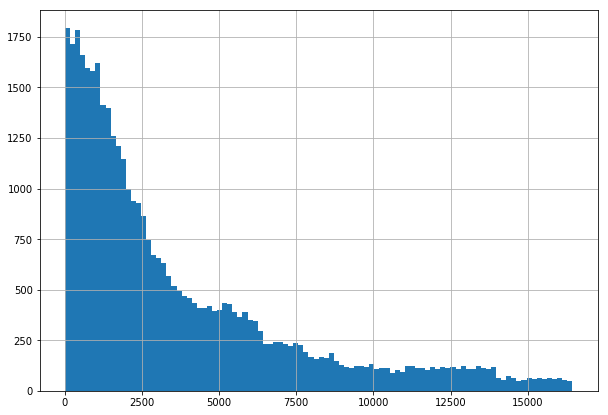

In [46]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

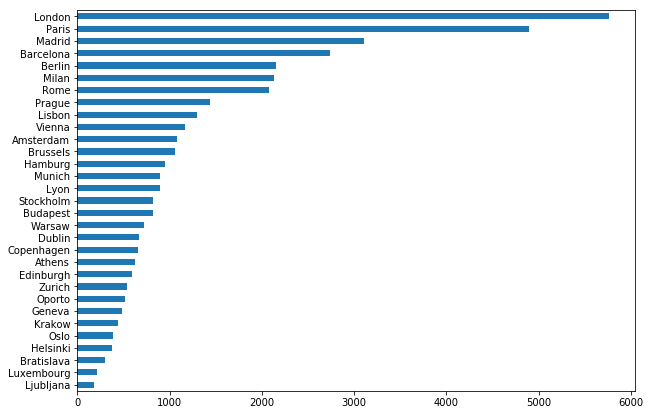

In [47]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

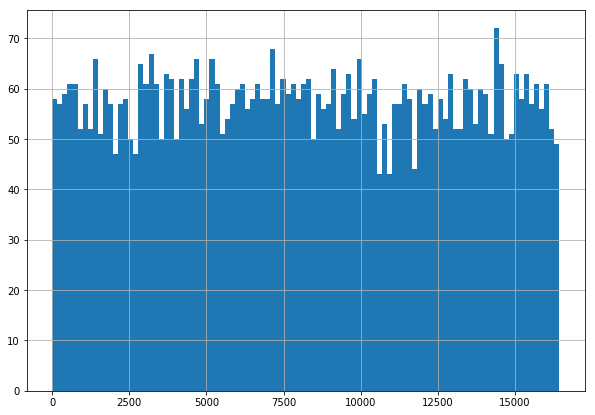

In [48]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

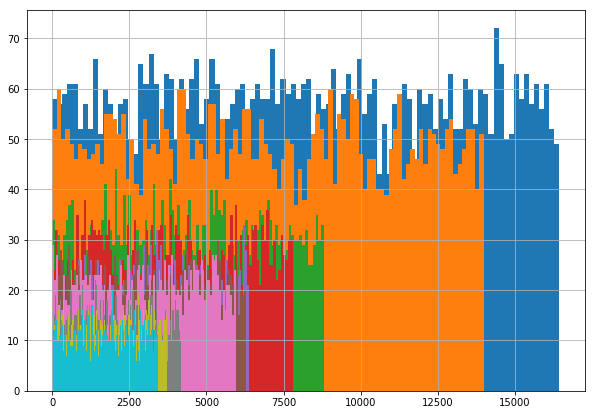

In [49]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.


### Посмотрим распределение целевой переменной

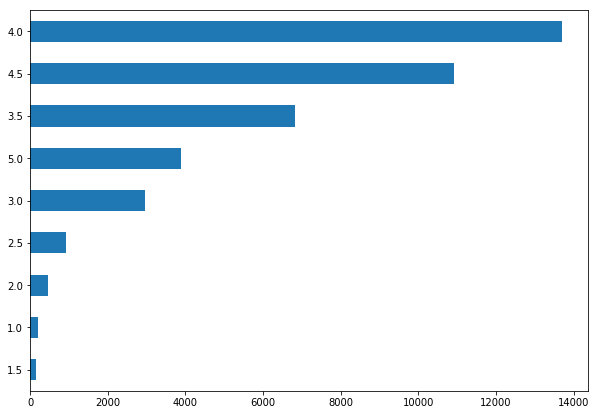

In [50]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

Наибольшее количество ресторанов имеют рейтинг 4

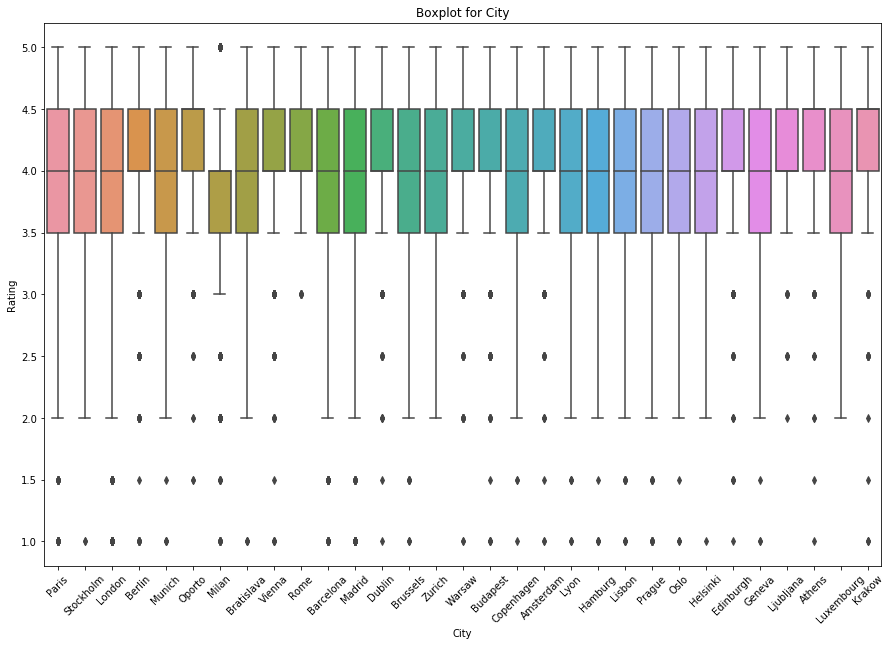

In [51]:
# Построим боксплоты для рейтинга
fig, ax = plt.subplots(figsize = (15, 10))
sns.boxplot(x = 'City', y = 'Rating',data=df_train)
plt.xticks(rotation=45)
ax.set_title('Boxplot for City')
plt.show()

Рестораны Милана заметно отличаются распределением оценок и наличием оценок = 5 а рестораны Рима тем что нет оценок ниже 3

### Посмотрим распределение целевой переменной относительно признака

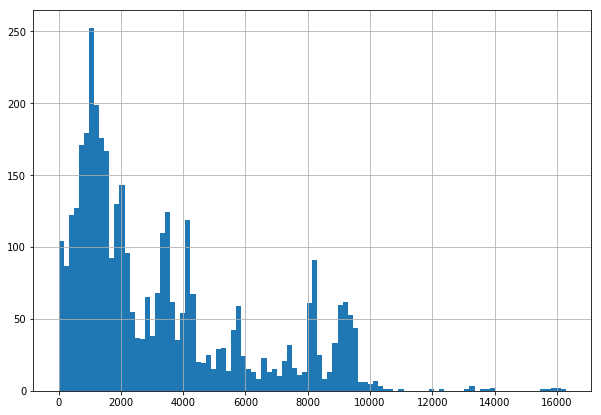

In [52]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

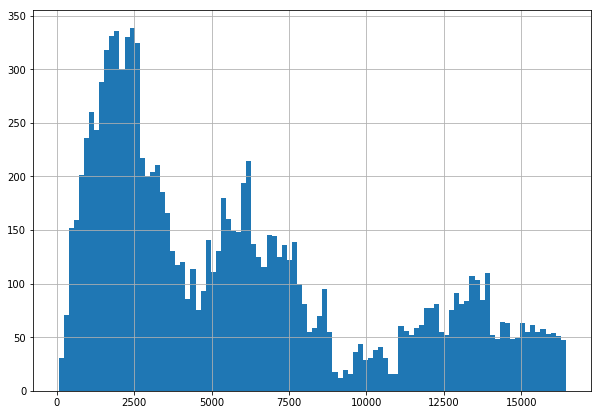

In [53]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

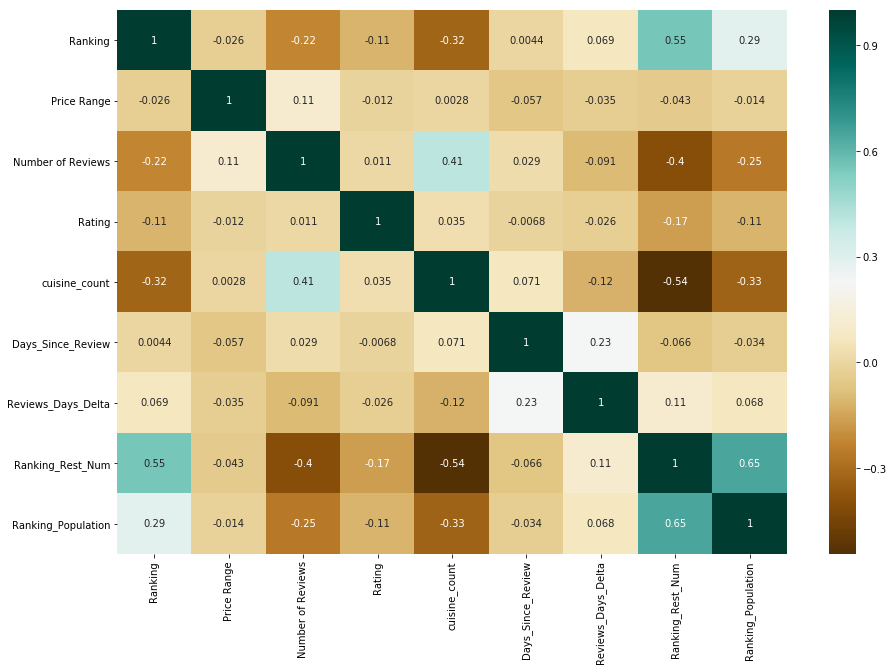

In [54]:
#plt.rcParams['figure.figsize'] = (15,10)
#sns.heatmap(data.drop(['sample'], axis=1).corr(),cmap="BrBG")
#data.drop(['sample'], axis=1).corr()

plt.rcParams['figure.figsize'] = (15,10)
data_cor = data[['Cuisine Style', 'Ranking', 'Price Range', 'Number of Reviews', 'Rating', 'cuisine_count',
                  'Days_Since_Review', 'Reviews_Days_Delta', 'Ranking_Rest_Num', 'Ranking_Population']]
sns.heatmap(data_cor.corr(), annot=True, cmap='BrBG')

 По графику видно, что слишком скоррелированных с целевой переменной признаков у нас нет

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [55]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [56]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['URL_TA','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # добавим новый признак в нашу модель - 0 будет соответствовать уникальному ресторану (id = 1) 
    # а 1 будет отвечать сети ресторанов (id > 1)
    restaurant_chain = df_output['Restaurant_id'].value_counts()[df_output['Restaurant_id'].value_counts() > 1].index.tolist()
    df_output['restaurant_chain'] = df_output[df_output['Restaurant_id'].isin(restaurant_chain)].Restaurant_id.apply(lambda x: 1)
    df_output['restaurant_chain'] = df_output['restaurant_chain'].fillna(0) # заполняем остаток 0

    # выполним преобразование данных 'Cuisine Style'    
    df_output['Cuisine Style'] = df_output['Cuisine Style'].fillna('European')
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: str(x).replace('[',''))
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: str(x).replace(']',''))
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: str(x).replace(' ',''))
    df_output['cuisine_style'] = df_output['Cuisine Style'].apply(lambda x:x.split(','))

    # заполним наиболее частым значением 'Price Range'
    df_output['Price Range'] = df_output['Price Range'].fillna(2)
    median = df_output['Number of Reviews'].median() # посчитаем медиану и заполним все NA
    df_output['Number of Reviews'] = df_output['Number of Reviews'].apply (lambda x: median if pd.isnull(x) else x)
    df_output['Reviews'] = df_output['Reviews'].fillna('[[], []]')
    
        
    # ################### 3. Encoding ############################################################## 
    # города закодируем с помощью One-Hot Encoding
    df_output['City_name'] = df_output['City']
    df_output = pd.get_dummies(df_output, columns=['City'], dummy_na=True)

    # Создадим признак, содержащий количество кухонь, представленных в ресторане
    df_output['cuisine_count'] = df_output['cuisine_style'].apply(lambda x: len(x))
    
    # рассмотрим уже созданный признак cuisine_style и создадим новые признаки этом основании
    # представим что каждому виду кухни будет соответствовать 1, при отсутствии этого вида кухни 0  
    # Разбивка на кухни показала худший результат 0.20826 поэтому не включаем в обработку
 
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код на генерацию новых фитчей
    # выполним преобразование через словарь price_dict
    price_dict = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
    df_output['Price Range'].replace(price_dict, inplace=True)

    # На основе дат добавим признаки количества дней между двумя последними отзывами и количество дней с момента последнего отзыва
    pattern = re.compile('\'\d+\/\d+\/\d+\'')
    dates = df_output['Reviews'].apply(pattern.findall)
    # врeменные признаки
    df_output['date1'] = pd.to_datetime(dates.apply(lambda x: x[0] if len(x) > 0 else None))
    df_output['date2'] = pd.to_datetime(dates.apply(lambda x: x[1] if len(x) > 1 else None))
    def days_since_last_review(r):
        '''
        Считает количество дней с последней даты отзыва. Учитывает отсутствие одной из дат и пропуск (возвращает
        0 в последнем случае)
        '''
        datetime_now = datetime.now();
        if pd.notna(r.date1) and pd.notna(r.date2):
            if r.date1 > r.date2:
                return (datetime_now - r.date1).days
            else:
                return (datetime_now - r.date2).days
        else:
            if pd.notna(r.date1):
                return (datetime_now - r.date1).days
            if pd.notna(r.date2):
                return (datetime_now - r.date2).days        
        return 0 

    def reviews_days_delta(r):
        '''
        Считает количество дней между двумя отзывами. Учитывает отсутствие (одной из) дат - возвращает 0 в данном
        случае.
        '''
        if pd.notna(r.date1) and pd.notna(r.date2):
            return abs((r.date1 - r.date2).days)
        else:
            return 0

    df_output['Days_Since_Review'] = df_output.apply(lambda row: days_since_last_review(row), axis=1)
    df_output['Reviews_Days_Delta'] = df_output.apply(lambda row: reviews_days_delta(row), axis=1)    
    
    #население территории города
    city_population = {'Paris':13024, 'Stockholm':2391, 'London':14257, 
                       'Berlin':6144, 'Munich':5991, 'Oporto':1721,
                       'Milan':4336, 'Bratislava':659, 'Vienna':2600, 
                       'Rome':4342, 'Barcelona':5474, 'Madrid':6791,
                       'Dublin':1417, 'Brussels':2500, 'Zurich':415, 
                       'Warsaw':3100, 'Budapest':3011, 'Copenhagen':2057,
                       'Amsterdam':2480, 'Lyon':2323, 'Hamburg':5107, 
                       'Lisbon':2827, 'Prague':2677, 'Oslo':1588,
                       'Helsinki':1525, 'Edinburgh':901, 'Geneva':201, 
                       'Ljubljana':537, 'Athens':2928,'Luxembourg':633, 
                       'Krakow':1752}

    #количество ресторанов в городе
    rest_per_city = df_output.City_name.value_counts().to_dict()
    df_output['Ranking_Rest_Num'] = df_output.apply(lambda r: (r['Ranking'] / rest_per_city[r.City_name]), axis=1)
    df_output['Ranking_Population'] = df_output.apply(lambda r: (r['Ranking'] / city_population[r.City_name]), axis=1)
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(['date1', 'date2'], inplace=True, axis=1)

    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [57]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Price Range,Number of Reviews,sample,Rating,restaurant_chain,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,cuisine_count,Days_Since_Review,Reviews_Days_Delta,Ranking_Rest_Num,Ranking_Population
11395,3673.0,2,126.0,1,4.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,5,1248,17,0.601343,0.282018
29107,1002.0,2,11.0,1,4.5,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0.875109,0.167251
20829,3972.0,2,3.0,1,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,2.187225,1.483750
3867,1484.0,2,6.0,0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1387,0,1.251265,0.290582
41823,1604.0,2,87.0,1,4.5,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1297,193,0.472459,0.293022
19265,7603.0,2,73.0,1,3.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,1291,148,1.993968,1.119570
39841,1600.0,2,3.0,1,4.5,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,4614,0,1.729730,0.516129
14951,89.0,2,658.0,1,4.0,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1299,22,0.114691,0.030396
31318,3501.0,2,33.0,1,5.0,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1294,0,1.294270,0.569824
26076,1503.0,2,9.0,1,4.0,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1265,63,1.797847,1.060692


In [58]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 43 columns):
Ranking               50000 non-null float64
Price Range           50000 non-null int64
Number of Reviews     50000 non-null float64
sample                50000 non-null int64
Rating                50000 non-null float64
restaurant_chain      50000 non-null float64
City_Amsterdam        50000 non-null uint8
City_Athens           50000 non-null uint8
City_Barcelona        50000 non-null uint8
City_Berlin           50000 non-null uint8
City_Bratislava       50000 non-null uint8
City_Brussels         50000 non-null uint8
City_Budapest         50000 non-null uint8
City_Copenhagen       50000 non-null uint8
City_Dublin           50000 non-null uint8
City_Edinburgh        50000 non-null uint8
City_Geneva           50000 non-null uint8
City_Hamburg          50000 non-null uint8
City_Helsinki         50000 non-null uint8
City_Krakow           50000 non-null uint8
City_Lisbon           5

In [59]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [60]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [61]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 42), (40000, 42), (40000, 41), (32000, 41), (8000, 41))

# Model 
Сам ML

In [62]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [63]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [64]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [65]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20486125


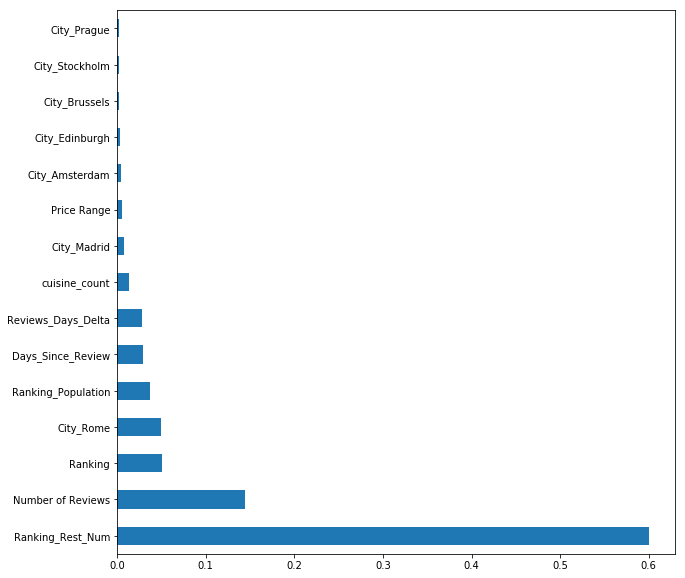

In [66]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [67]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,restaurant_chain,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,City_Milan,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,cuisine_count,Days_Since_Review,Reviews_Days_Delta,Ranking_Rest_Num,Ranking_Population
3995,2247.0,2,7.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1711,0,1.557173,0.864231
1110,180.0,2,475.0,0.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,1233,45,0.053019,0.032883
8971,433.0,1,161.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,1311,1,0.167246,0.099724
9435,2295.0,2,3.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,2105,132,1.263767,0.857303
6487,401.0,2,159.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1233,31,0.148244,0.065267
2907,1072.0,3,767.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,1262,53,0.149034,0.075191
2924,2537.0,2,54.0,0.0,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1342,74,0.937893,0.412923
2047,1421.0,2,580.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,1256,16,0.197553,0.099670
7273,1351.0,2,4.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2416,0,1.649573,0.656782
6514,6041.0,2,67.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,1381,84,1.584317,0.889560


In [68]:
test_data = test_data.drop(['Rating'], axis=1)

In [69]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [70]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [71]:
predict_submission

array([3.035, 4.28 , 4.465, ..., 3.03 , 4.46 , 4.4  ])

In [72]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.035
1,id_1,4.280
2,id_2,4.465
3,id_3,4.315
4,id_4,4.505
5,id_5,4.470
6,id_6,2.485
7,id_7,2.315
8,id_8,4.075
9,id_9,4.585
